In [1]:
%load_ext lab_black

In [2]:
from dateutil.relativedelta import relativedelta
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from math import ceil
from matplotlib.lines import Line2D

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

In [3]:
# Set up plotting
current_palette = sns.color_palette()
LANGUAGE_COLORS = {
    "Chinese": current_palette[0],
    "English": current_palette[1],
    "Spanish": current_palette[2],
    "Sign": current_palette[3],
    "Animal Sound": current_palette[4],
}

# Set plotting style
sns.set_style("white")

# Plot constants
WIDTH = 12
HEIGHT = 7

# Plot constants
X_MIN, X_MAX = ("2020-10-01", "2021-12-15")

Y_MIN, Y_MAX = (0.38041005786659937, 256.8277838060705)

TITLE_SIZE = 26
AXIS_TITLE_SIZE = 20

pd.set_option("display.max_rows", None)

%matplotlib inline

In [4]:
NAME = "Sebastian"
BIRTH_DATE = datetime.date(2019, 10, 1)

## Normalize the data

In [5]:
def load_data(
    file, column_names=["timestamp", "word", "description", "language", "first_use_alt"]
):
    words_df = pd.read_csv(
        file, names=column_names, header=0, parse_dates=["timestamp", "first_use_alt"]
    )

    # Google changed how the form worked in the middle of my data collection, making it very hard to enter dates,
    # so I started using the timestamp as the entry time
    words_df["first_use"] = np.where(
        words_df["first_use_alt"].notnull(),
        words_df["first_use_alt"],
        words_df["timestamp"],
    )

    # Then keep just the day, instead of the hour:minute:second, since we do not have that level of precision and it makes grouping harder
    words_df["first_use"] = words_df["first_use"].dt.date

    # Sort by first use
    words_df = words_df.sort_values("first_use")

    # Lowercase all words
    words_df["word"] = words_df["word"].str.lower().str.strip()

    # Remove paranthetical remarks
    words_df["word"] = words_df["word"].str.split("(").str[0].str.strip()

    # Save the first duplicate, remove the rest
    words_df = words_df.drop_duplicates(subset=["language", "word"])
    words_df = words_df.reset_index(drop=True)

    # Sort by first_use date and then cumulative count
    words_df = words_df.sort_values("first_use")
    words_df["count"] = words_df.groupby("language").cumcount()
    # `.cumcount()` starts from 0, but we want the first word to be 1
    words_df["count"] += 1

    words_df = words_df.dropna(axis="index", subset=["word"])

    return words_df

In [6]:
def generate_language_day_count_df(words_df):
    # Select just the columns we need to plot
    language_day_count_df = words_df[["first_use", "count", "language"]].reset_index(
        drop=True
    )

    # Add a common start and end point
    before_first_day = pd.Timestamp(year=2018, month=12, day=1)
    min_day = words_df["first_use"].min()
    max_day = words_df["first_use"].max()
    for language in language_day_count_df["language"].unique():
        max_count = language_day_count_df[
            language_day_count_df["language"] == language
        ]["count"].max()
        new_df = pd.DataFrame(
            [(min_day, 0, language), (max_day, max_count, language)],
            columns=["first_use", "count", "language"],
        )
        language_day_count_df = language_day_count_df.append(new_df)

    return language_day_count_df.sort_values(["first_use", "count"]).reindex()

In [7]:
words_df = load_data("./ash_words.csv")
language_day_count_df = generate_language_day_count_df(words_df)

In [8]:
words_df

,timestamp,word,description,language,first_use_alt,first_use,count
0,2020-10-11 09:13:05,pointing,NaN,Sign,2020-10-11,2020-10-11,1
1,2020-10-15 17:32:52,pick me up,Arms up,Sign,2020-10-14,2020-10-14,2
2,2020-12-03 17:17:18,milk,NaN,Sign,NaT,2020-12-03,3
3,2020-12-03 17:17:26,milk,NaN,Chinese,NaT,2020-12-03,1
4,2020-12-11 12:14:56,mama,NaN,Chinese,NaT,2020-12-11,2
5,2021-01-23 18:40:22,patting mouth,Making wawa sound,Sign,2021-01-03,2021-01-03,4
6,2021-01-17 08:53:13,no,Head shake,Sign,NaT,2021-01-17,5
7,2021-01-23 18:36:05,clapping,NaN,Sign,NaT,2021-01-23,6
8,2021-03-07 07:32:00,dad,Daddy,English,2021-03-03,2021-03-03,1
9,2021-03-07 07:32:47,chicken,Gai,Chinese,2021-03-05,2021-03-05,3


# Plotting Functions

In [9]:
def word_coordinates(df, count_df, word, language):
    """Return the timestamp of first useage, and the number of words known in
    the language at the time, for a given word.
    """
    correct_langauge = df["language"] == language

    compare_word = word.lower()
    correct_word = df["word"].str.contains(compare_word)

    filtered = df[correct_langauge & correct_word]
    timestamp = filtered["first_use"]

    # Join on the timestamp
    merged = pd.merge(filtered, count_df, on=["first_use", "language"])

    return timestamp.values[0], merged["count_y"].values[0]

In [10]:
def draw_legend(plt):
    """Draw the legend on the specified plot.

    Args:
        plt (matplotlib.pyplot): pyplot object

    """
    leg = plt.legend(
        loc="upper left",
        fontsize=18,
        ncol=1,
        frameon=1,
        fancybox=True,
        # The bellow commands remove the lines in the legend
        handlelength=0,
        handletextpad=0,
        markerscale=0,
    )

    # Turn on and theme the frame
    frame = leg.get_frame()
    frame.set_linewidth(1)
    frame.set_alpha(1)
    frame.set_facecolor("white")
    frame.set_edgecolor("black")

    # Set the legend text color to match the line color
    handles, _ = ax.get_legend_handles_labels()
    texts = leg.get_texts()
    for _, text in zip(handles, texts):
        text.set_color(LANGUAGE_COLORS[text.get_text()])

    fig.tight_layout()

In [11]:
def age_to_timestamp(age):
    """Returns a Timestamp for when Theo turned a specific age in months."""
    born = BIRTH_DATE
    current = born + relativedelta(months=age)

    return current

In [12]:
def timestamp_to_age(timestamp):
    delta = timestamp - BIRTH_DATE
    return delta.days

In [13]:
def draw_age_tick_labels(ax, first=11, until=36):
    """ """
    # Set the major ticks as dates
    ages = list(range(first, until))
    major_ticks = np.array([age_to_timestamp(age) for age in ages])
    ax.set_xticks(major_ticks)

    # Read back the x-values of the major ticks
    major_ticks_values = np.array(ax.get_xticks())

    # Put the minor ticks halfway between the majors
    half = (major_ticks_values[1] - major_ticks_values[0]) / 2
    minor_ticks = major_ticks_values + half
    ax.set_xticks(minor_ticks, minor=True)

    # Create the text of the labels
    tick_labels = [str(age) for age in ages]
    # If we go up to a year, replace the months with year
    for month_count, year_str in ((12, "1 Year"), (24, "2 Years")):
        try:
            i = ages.index(month_count)
            tick_labels[i] = year_str
        except ValueError:
            continue

    # Disable major tick labels
    ax.set_xticklabels([], minor=False)
    # Set minor tick labels
    ax.set_xticklabels(tick_labels, minor=True)

In [14]:
def annotate_word(df, count_df, ax, word, language, xytext, alt_word, arrowstyle="->"):
    """Draw an annotation on the Day of Year plot."""
    # Get the x and y coordinates for the word
    x_pos, y_pos = word_coordinates(df, count_df, word, language)

    y_pos = y_pos if y_pos != 0 else 1  # Fix error with first word

    # Draw a circle at that point
    point_color = LANGUAGE_COLORS[language]
    plt.scatter(
        [x_pos],
        [y_pos],
        s=80,
        facecolors=point_color,
        edgecolors=point_color,
        linewidth=2,
        label="_nolegend_",
        zorder=2,
    )

    # Add an arrow and text annotating it
    if alt_word is not None:
        word = alt_word

    ax.annotate(
        word,
        (x_pos, y_pos),
        xytext=xytext,
        textcoords="offset points",
        arrowprops=dict(
            arrowstyle=arrowstyle, connectionstyle="arc3", color="black", linewidth=1.5
        ),
        size=16,
        color=point_color,
        zorder=3,
    )

In [15]:
def bulk_annotate_words(df, count_df, ax, word_pairs):
    for word_pair in word_pairs:
        try:
            word, language, xytext, alt_word = word_pair
            annotate_word(df, count_df, ax, word, language, xytext, alt_word)
        except:
            print(word, language)

In [16]:
def draw_bands(ax):
    """Add grey bands to the plot with a sepcified width.

    Args:
        ax: a matplotlib axes object

    """
    ticks = ax.get_xticks(minor=False)
    band_width = ticks[1] - ticks[0]

    for i in range(0, len(ticks), 2):
        try:
            left_tick = ticks[i]
            right_tick = ticks[i + 1]
        except:
            break
        else:
            ax.axvspan(left_tick, right_tick, color="0.97", zorder=-2)

    # Have to add an extra band if odd ticks
    x_lims = ax.get_xlim()
    if len(ticks) % 2:
        last_tick = ticks[-1]
        ax.axvspan(last_tick, last_tick + band_width, color="0.97", zorder=-2)

    ax.set_xlim(x_lims)

In [17]:
def draw_steps(ax, ldc_df, language, linewidth=2.5, alpha=1, linestyle="-", zorder=1):
    tmp_df = ldc_df[ldc_df["language"] == language]

    ax.step(
        x=tmp_df["first_use"].values,
        y=tmp_df["count"].values,
        color=LANGUAGE_COLORS[language],
        linewidth=linewidth,
        label=language,
        zorder=zorder,
        alpha=alpha,
        where="post",
        linestyle=linestyle,
    )

## Make Words in Time Plot

In [18]:
def make_plot_background(
    ax,
    words_df,
    language_day_count_df,
    word_pairs=None,
    languages=["Chinese", "English", "Spanish", "Sign", "Animal Sound"],
    legend=True,
):
    for language in languages:
        draw_steps(ax, language_day_count_df, language)

    # Set titles
    ax.set_ylabel("Words Spoken", fontsize=AXIS_TITLE_SIZE)
    ax.set_xlabel("Age (Months)", fontsize=AXIS_TITLE_SIZE)

    # Annotate word pairs
    if word_pairs is not None:
        bulk_annotate_words(words_df, language_day_count_df, ax, WORD_PAIRS)

    ax.set_yscale("log")
    if legend:
        draw_legend(plt)

    # Plot the gird and grey month bands
    # We need to set the age bands for the tick labels using the maximum of the data
    age_in_months = ceil(
        timestamp_to_age(language_day_count_df["first_use"].max()) / 30
    )
    plt.minorticks_on()
    draw_age_tick_labels(ax, until=age_in_months)
    plt.tick_params(axis="y", which="major", labelsize=15)
    plt.tick_params(axis="x", which="minor", labelsize=15)
    plt.grid(True)
    draw_bands(ax)

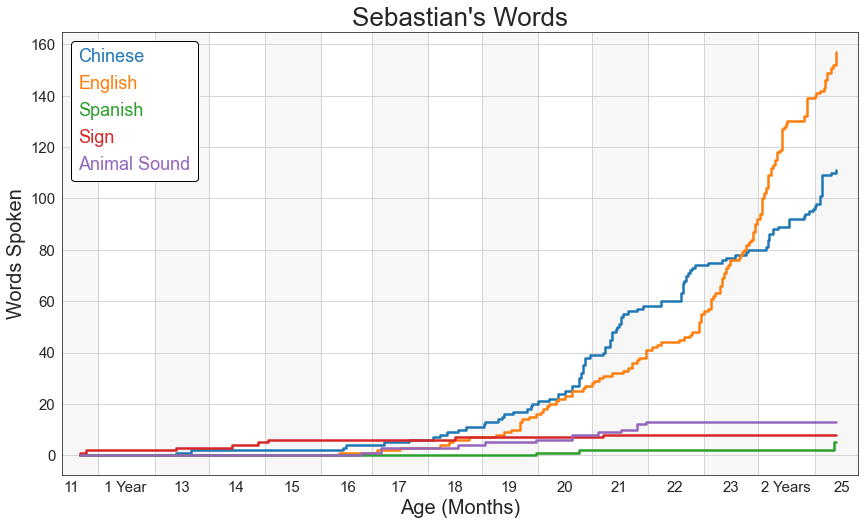

In [19]:
fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))

make_plot_background(ax, words_df, language_day_count_df)

ax.set_yscale("linear")

ax.set_title(f"{NAME}'s Words", fontsize=TITLE_SIZE)

plt.xlim(X_MIN, X_MAX)
# plt.ylim(Y_MIN, Y_MAX)

fig.patch.set_alpha(1)

# Save to disk
for ext in ("png", "svg"):
    fig.savefig(f"/tmp/child2_total_words_linear.{ext}", bbox_inches="tight")

In [20]:
WORD_PAIRS = (
    #
    # Chinese
    #
    ("Milk", "Chinese", (-50, 15), None),
    ("Mama", "Chinese", (20, -35), None),
    ("Chicken", "Chinese", (-90, -10), None),
    ("TV", "Chinese", (-50, -5), None),
    ("Hot", "Chinese", (-50, -5), None),
    ("Big Brother", "Chinese", (-100, -15), None),
    ("Little Brother", "Chinese", (-100, 5), None),
    ("Grandfather", "Chinese", (-160, 10), "Maternal Grandpa"),
    ("Grandmother", "Chinese", (-130, 17), "Maternal Grandma"),
    ("Bike", "Chinese", (-60, 8), None),
    ("Shoe", "Chinese", (-70, 15), None),
    ("Hurt", "Chinese", (-50, 5), None),
    ("Eyore", "Chinese", (-70, 15), None),
    ("No", "Chinese", (-55, 25), None),
    ("Dad", "Chinese", (-35, 35), None),
    ("Airplane", "Chinese", (-50, 15), None),
    ("Dinosaur", "Chinese", (-85, 25), None),
    ("Color", "Chinese", (-30, 15), None),
    ("Balloon", "Chinese", (-80, 25), None),
    ("1", "Chinese", (0, -30), "One"),
    #
    # English
    #
    ("Bike", "English", (0, -35), None),
    ("Blue", "English", (-20, -30), None),
    ("Cory", "English", (20, -23), None),
    ("Dad", "English", (-60, 4), None),
    ("Dinosaur", "English", (20, -20), None),
    ("Eyore", "English", (-20, -50), None),
    ("Gondola", "English", (-120, 15), None),
    ("Google", "English", (10, -18), None),
    ("Halloween", "English", (-70, 20), None),
    ("Kitty", "English", (0, -40), None),
    ("Milk", "English", (20, -20), None),
    ("Mom", "English", (-5, -25), None),
    ("Paternal grandmother", "English", (20, -20), "Grandma"),
    ("Shark", "English", (0, -35), None),
    ("Snowman", "English", (-50, 8), None),
    ("Theodore", "English", (40, -20), None),
    ("2", "English", (35, -20), "Two"),
    #
    # Spanish
    #
    ("Cookie", "Spanish", (-50, 15), None),
    ("Monkey", "Spanish", (-80, 15), None),
    ("Open", "Spanish", (-50, 15), None),
    #
    # Animal Sound
    #
    ("Cat", "Animal Sound", (20, -25), None),
    ("Cow", "Animal Sound", (20, -25), None),
    ("Dog", "Animal Sound", (20, -25), None),
    ("Horse", "Animal Sound", (20, -25), None),
    ("Hulk", "Animal Sound", (20, -25), None),
    ("Lion", "Animal Sound", (20, -25), None),
    ("Monkey", "Animal Sound", (40, -35), None),
    ("Owl", "Animal Sound", (20, 15), None),
    ("Rooster", "Animal Sound", (20, -25), None),
    ("Tiger", "Animal Sound", (20, -10), None),
    #
    # Sign
    #
    ("Clapping", "Sign", (-30, 25), None),
    ("Milk", "Sign", (-50, 10), None),
    ("No", "Sign", (-30, 15), None),
    ("Patting mouth", "Sign", (-100, 15), None),
    ("Pick me up", "Sign", (-10, 15), None),
    ("Pointing", "Sign", (10, -35), None),
)

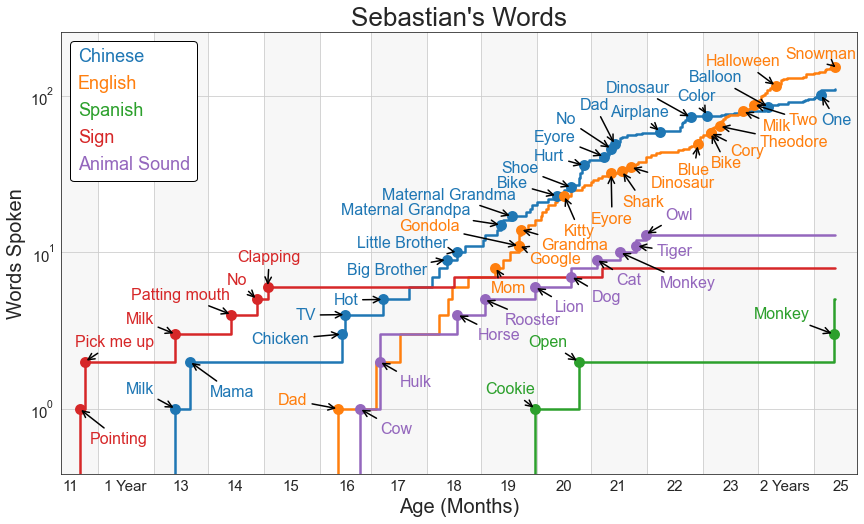

In [21]:
fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))

make_plot_background(ax, words_df, language_day_count_df, word_pairs=WORD_PAIRS)

ax.set_title(f"{NAME}'s Words", fontsize=TITLE_SIZE)

plt.xlim(X_MIN, X_MAX)
plt.ylim(Y_MIN, Y_MAX)

fig.patch.set_alpha(1)

# Save to disk
for ext in ("png", "svg"):
    fig.savefig(f"/tmp/child2_first_words.{ext}", bbox_inches="tight")